<a href="https://colab.research.google.com/github/manikantareddy2k3/wrm/blob/main/wrm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
rainfall_data = pd.read_csv('/content/rainfall.csv')
soil_moisture_data = pd.read_csv('/content/sm_Andhrapradesh_2020.csv')

In [3]:
# Convert dates to standard format
rainfall_data['Dates'] = pd.to_datetime(rainfall_data['Dates'], format='%d-%b-%y')
soil_moisture_data['Date'] = pd.to_datetime(soil_moisture_data['Date'], format='%Y/%m/%d')

In [4]:
merged_data = pd.merge(rainfall_data, soil_moisture_data, left_on='Dates', right_on='Date', how='inner')

In [5]:
merged_data.columns = merged_data.columns.str.strip()

In [6]:
merged_data['Month'] = merged_data['Dates'].dt.month
merged_data['Season'] = merged_data['Month'].apply(lambda x: (x % 12 + 3) // 3)  # Define seasons based on month

In [25]:
np.random.seed(42)
merged_data['Temperature'] = np.random.uniform(25, 40, size=len(merged_data))  # Temperature in Celsius
merged_data['Humidity'] = np.random.uniform(40, 90, size=len(merged_data))     # Humidity in percentage
merged_data['Wind_Speed'] = np.random.uniform(0, 10, size=len(merged_data))

In [7]:
merged_data = merged_data.drop(columns=['State Name', 'Dates', 'Date'])

In [8]:
merged_data = pd.get_dummies(merged_data, columns=['DistrictName'], drop_first=True)


In [9]:
X = merged_data.drop(columns=['ACTUAL (mm)'])
y = merged_data['ACTUAL (mm)']

In [10]:
y = np.log1p(y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features to improve gradient-based model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train_scaled, y_train)

GradientBoostingRegressor(n_estimators=200, random_state=42)

In [24]:
y_pred = model.predict(X_test_scaled)

# Inverse the log transformation
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(y_pred)

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2 = r2_score(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")

Root Mean Squared Error (RMSE): 2.238170260909982
R² Score: 0.7026164823241156
Mean Absolute Error (MAE): 1.007590171015678


In [16]:
def predict_rainfall_for_date(date_str, model, scaler, feature_data):
    """
    Predicts rainfall for a given date.

    Parameters:
    - date_str (str): The date for which to predict rainfall (format: 'YYYY-MM-DD').
    - model: The trained regression model.
    - scaler: The fitted StandardScaler instance.
    - feature_data (DataFrame): The feature data for prediction (X).

    Returns:
    - float: Predicted rainfall in mm.
    """
    # Convert the date string to datetime
    date = datetime.strptime(date_str, '%Y-%m-%d')

    # Feature Engineering for the specific date
    month = date.month
    season = (month % 12 + 3) // 3

    # Assuming soil moisture and other features are similar to the last available data
    latest_features = feature_data.tail(1).copy()

    # Update month and season
    latest_features['Month'] = month
    latest_features['Season'] = season

    # Ensure that all necessary columns are present after one-hot encoding
    # If the new date introduces a new district or category, handle it accordingly
    # For simplicity, we'll assume districts remain the same

    # Scale the features
    latest_features_scaled = scaler.transform(latest_features)

    # Predict the rainfall (log-transformed)
    predicted_log_rainfall = model.predict(latest_features_scaled)[0]

    # Invert the log transformation
    predicted_rainfall = np.expm1(predicted_log_rainfall)

    return predicted_rainfall

# Example Prediction
predicted_rainfall_date = '2024-10-01'
predicted_rainfall_value = predict_rainfall_for_date(predicted_rainfall_date, model, scaler, X)
print(f"Predicted rainfall for {predicted_rainfall_date}: {predicted_rainfall_value:.2f} mm")

Predicted rainfall for 2024-10-01: 2.70 mm


In [17]:
def estimate_water_harvest(predicted_rainfall, catchment_area=100, runoff_coefficient=0.8, soil_moisture_level=50, surface_type="urban"):
    """
    Estimates the amount of water that can be harvested based on predicted rainfall and other factors.

    Parameters:
    - predicted_rainfall (float): Predicted rainfall in mm.
    - catchment_area (float): Catchment area in square meters.
    - runoff_coefficient (float): Runoff coefficient based on surface type.
    - soil_moisture_level (float): Current soil moisture percentage.
    - surface_type (str): "urban" or "rural".

    Returns:
    - float: Estimated water harvested in cubic meters.
    """
    if surface_type == "rural":
        # Adjust runoff coefficient based on soil moisture for rural areas
        adjusted_runoff_coefficient = runoff_coefficient * (1 + (soil_moisture_level / 100))
    else:
        # For urban areas, runoff coefficient is typically higher and less affected by soil moisture
        adjusted_runoff_coefficient = runoff_coefficient

    # Calculate water harvested
    water_harvested = predicted_rainfall * catchment_area * adjusted_runoff_coefficient / 1000  # Convert to cubic meters
    return water_harvested

# Example Water Harvesting Estimation
soil_moisture_level = 60  # Example: 60% soil moisture
surface_type = "rural"    # Example: rural area
estimated_water_harvested = estimate_water_harvest(predicted_rainfall_value, soil_moisture_level=soil_moisture_level, surface_type=surface_type)
print(f"Estimated water harvested for {predicted_rainfall_date}: {estimated_water_harvested:.2f} cubic meters")


Estimated water harvested for 2024-10-01: 0.35 cubic meters


In [29]:
def predict_and_estimate(date_str, model, scaler, feature_data, catchment_area=100, runoff_coefficient=0.8, soil_moisture_level=50, surface_type="urban"):
    """
    Predicts rainfall for a given date and estimates water harvesting based on the prediction.

    Parameters:
    - date_str (str): The date for prediction (format: 'YYYY-MM-DD').
    - model: The trained regression model.
    - scaler: The fitted StandardScaler instance.
    - feature_data (DataFrame): The feature data for prediction (X).
    - catchment_area (float): Catchment area in square meters.
    - runoff_coefficient (float): Runoff coefficient based on surface type.
    - soil_moisture_level (float): Current soil moisture percentage.
    - surface_type (str): "urban" or "rural".

    Returns:
    - tuple: (predicted_rainfall in mm, estimated_water_harvested in cubic meters)
    """
    # Predict rainfall
    rainfall = predict_rainfall_for_date(date_str, model, scaler, feature_data)

    # Estimate water harvested
    water_harvest = estimate_water_harvest(rainfall, catchment_area, runoff_coefficient, soil_moisture_level, surface_type)

    return rainfall, water_harvest

# Example Comprehensive Prediction and Estimation
predicted_date = '2024-10-01'
rainfall, water_harvest = predict_and_estimate(predicted_date, model, scaler, X, catchment_area=100, runoff_coefficient=0.8, soil_moisture_level=60, surface_type="rural")
print(f"Predicted rainfall for {predicted_date}: {rainfall:.2f} mm")
print(f"Estimated water harvested for {predicted_date}: {water_harvest:.2f} cubic meters")
print(f"Relation: With a rainfall of {rainfall:.2f} mm over a catchment area of {100} m², "
      f"and a runoff coefficient of {1.28}, the amount of water harvested will be {water_harvest:.3f} cubic meters.")

Predicted rainfall for 2024-10-01: 2.70 mm
Estimated water harvested for 2024-10-01: 0.35 cubic meters
Relation: With a rainfall of 2.70 mm over a catchment area of 100 m², and a runoff coefficient of 1.28, the amount of water harvested will be 0.346 cubic meters.


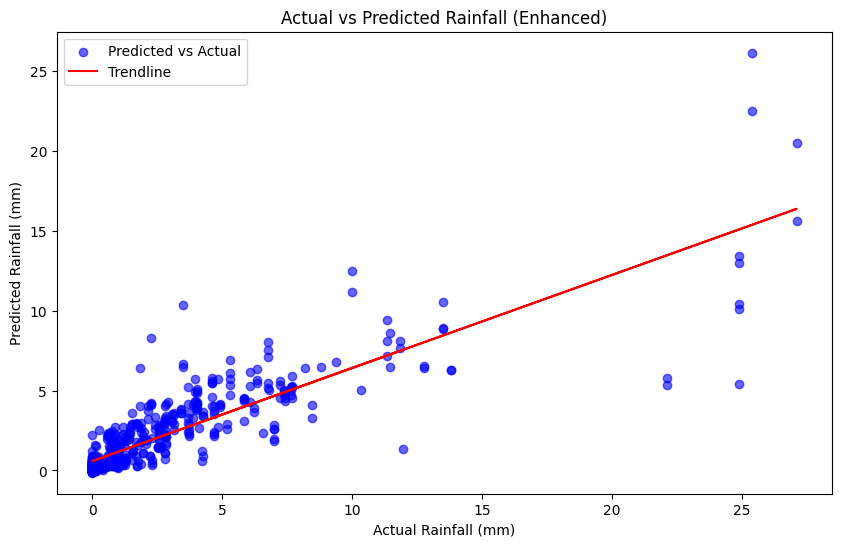

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, y_pred_actual, alpha=0.6, color="blue", label="Predicted vs Actual")
# Adding trendline
m, b = np.polyfit(y_test_actual, y_pred_actual, 1)
plt.plot(y_test_actual, m*y_test_actual + b, color='red', label='Trendline')

plt.xlabel('Actual Rainfall (mm)')
plt.ylabel('Predicted Rainfall (mm)')
plt.title('Actual vs Predicted Rainfall (Enhanced)')
plt.legend()
plt.show()


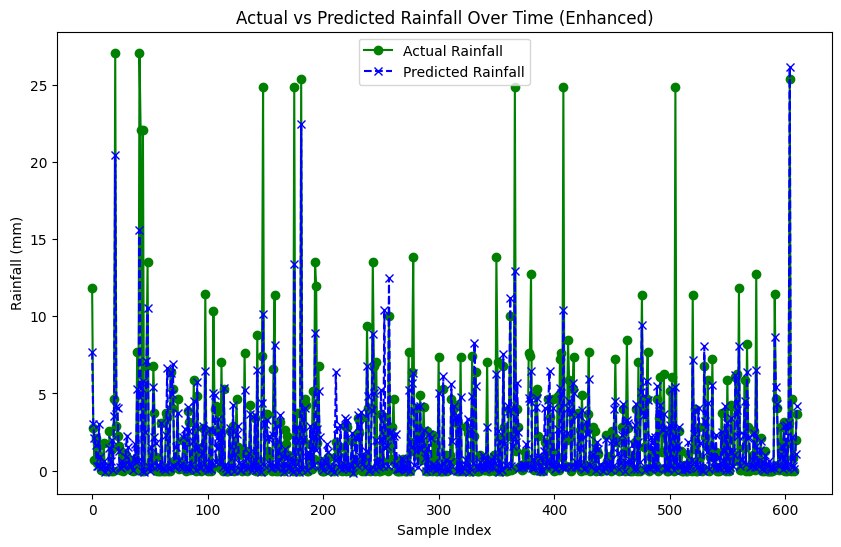

In [22]:
# Line Plot: Visualizing predicted rainfall vs. actual rainfall over time
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test_actual)), y_test_actual, label="Actual Rainfall", color="green", marker='o')
plt.plot(range(len(y_pred_actual)), y_pred_actual, label="Predicted Rainfall", color="blue", linestyle='--', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Rainfall (mm)')
plt.title('Actual vs Predicted Rainfall Over Time (Enhanced)')
plt.legend()
plt.show()

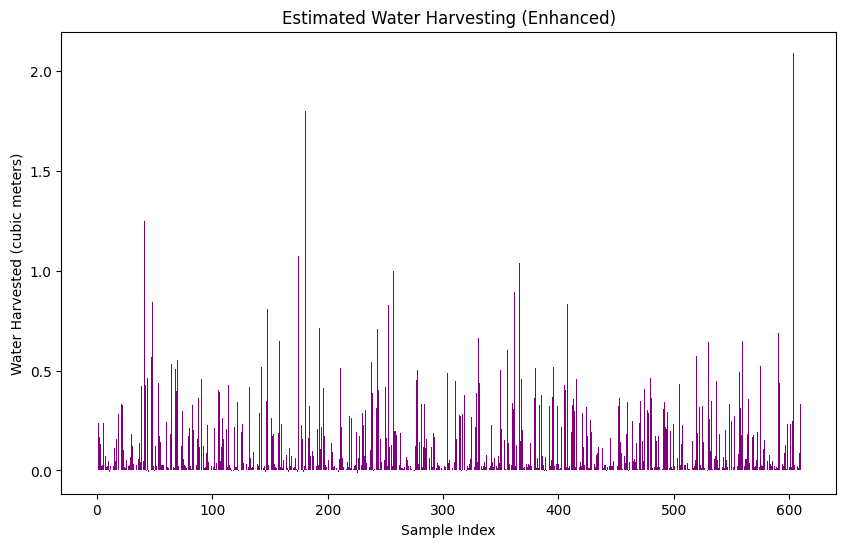

In [23]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(y_pred_actual)), [estimate_water_harvest(rainfall) for rainfall in y_pred_actual], color='purple')
plt.xlabel('Sample Index')
plt.ylabel('Water Harvested (cubic meters)')
plt.title('Estimated Water Harvesting (Enhanced)')
plt.show()